Import Library

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Membuat Dataset untuk Training, Validasi, dan Testing

In [3]:
# Variabel untuk menetapkan class pada gambar sesuai dengan nama dan urutannya
classes = {'fumio_kishida':0,'joe_biden':1,'narendra_modi':2, 'scott_morrison':3}

# Fungsi untuk mengembalikan nilai class, seperti 0 atau 1
def assign_label(img,class_num):
    return class_num

In [4]:
#Direktori dari masing-masing bagian dataset
train_path="dataset/train"
test_path="dataset/test"
valid_path="dataset/valid"

# Variabel untuk menyimpan value gambar dalam bentuk array untuk dataset training
x_train=[]
# Variabel untuk menyimpan value target dalam bentuk angka untuk dataset training
y_train=[]

# Fungsi untuk menyimpan value kedua variabel di atas sesuai dengan classnya masing-masing
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        label = assign_label(img, classes.get(folder))
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)
        y_train.append(label)

# Variabel untuk menyimpan value gambar dalam bentuk array untuk dataset testing
x_test=[]
# Variabel untuk menyimpan value target dalam bentuk angka untuk dataset testing
y_test=[]

# Fungsi untuk menyimpan value kedua variabel di atas sesuai dengan classnya masing-masing
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        label = assign_label(img, classes.get(folder))
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)
        y_test.append(label)

# Variabel untuk menyimpan value gambar dalam bentuk array untuk dataset validasi
x_val=[]
# Variabel untuk menyimpan value target dalam bentuk angka untuk dataset validasi
y_val=[]

# Fungsi untuk menyimpan value kedua variabel di atas sesuai dengan classnya masing-masing
for folder in os.listdir(valid_path):
    sub_path=valid_path+"/"+folder
    for img in os.listdir(sub_path):
        label = assign_label(img, classes.get(folder))
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)
        y_val.append(label)

In [5]:
# Mengubah tipe data pada masing-masing bagian dataset menjadi model numpy array (Value Gambar)
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

# Mengubah tipe data pada masing-masing bagian dataset menjadi model numpy array (Target)
train_y=np.array(y_train)
test_y=np.array(y_test)
val_y=np.array(y_val)

# Membagi nilai array pada variabel x untuk semua tipe dataset dengan 255, agar nilai pada array tersebut memiliki rentang 0 - 1
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

Meng-Improve Value dari Variabel X pada Semua Dataset dengan Pre-trained Model (VGG16)

In [6]:
# Meng-import library untuk menggunakan pre-trained model
from keras.applications import VGG16

# Menginisialisasi variabel dengan value, yaitu pre-trained model
pretrained_model = VGG16(include_top=False, weights='imagenet')

# Melakukan improvement pada variabel x di semua dataset yang nantinya akan disimpan pada variabel baru
train_x_vgg = pretrained_model.predict(train_x)
val_x_vgg = pretrained_model.predict(val_x)
test_x_vgg = pretrained_model.predict(test_x)



8/8 [==============================] - 15s 2s/step


Membuat Model untuk Training

In [7]:
# Membuat variabel untuk model
model = keras.models.Sequential([
    
    # Membuat layer inputan dengan syarat ukuran array 7 x 7 dengan jumlah chanel 512 (Pada saat proses improvement, terjadi perubahan dimensi array pada dataset)
    keras.layers.Flatten(input_shape=[7, 7, 512]),

    # Membuat dua hidden layer dengan masing-masing neuron berjumlah 300 dan 100 serta menggunakan fungsi aktivasi ReLU
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),

    # Membuat output layer dengan neuron berjumlah 4 (sesuai dengan class pada dataset) dan memiliki fungsi aktivasi softmax (karena class lebih dari 2)
    keras.layers.Dense(4, activation="softmax")
])

# Mengambil nilai semua layer pada inisialisasi sebelumnya
model.layers

# Melihat struktur model, seperti layer dan parameter pada model tersebut
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 300)               7526700   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 7557204 (28.83 MB)
Trainable params: 7557204 (28.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Meng-compile model dengan tipe loss categorical (karena lebih dari 2 class) dan optimizer menggunakan Adam
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Melakukan training dengan iterasi sebanyak 10 kali sekaligus melakukan validasi dengan metode Hold Out
model_fit = model.fit(train_x_vgg, train_y, epochs=10,
                    validation_data=(val_x_vgg, val_y))


Epoch 1/10


60/60 [==============================] - 8s 95ms/step - loss: 1.3060 - accuracy: 0.6000 - val_loss: 0.5294 - val_accuracy: 0.8167
Epoch 2/10
60/60 [==============================] - 5s 91ms/step - loss: 0.2135 - accuracy: 0.9349 - val_loss: 0.4133 - val_accuracy: 0.8417
Epoch 3/10
60/60 [==============================] - 5s 85ms/step - loss: 0.0688 - accuracy: 0.9911 - val_loss: 0.4238 - val_accuracy: 0.8500
Epoch 4/10
60/60 [==============================] - 5s 82ms/step - loss: 0.0218 - accuracy: 0.9990 - val_loss: 0.3638 - val_accuracy: 0.8917
Epoch 5/10
60/60 [==============================] - 5s 82ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.9042
Epoch 6/10
60/60 [==============================] - 5s 80ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3821 - val_accuracy: 0.8667
Epoch 7/10
60/60 [==============================] - 5s 82ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3798 - val_accuracy: 0.8917
Epoch 8/10

Melakukan Evaluasi pada Model yang Telah Dibuat

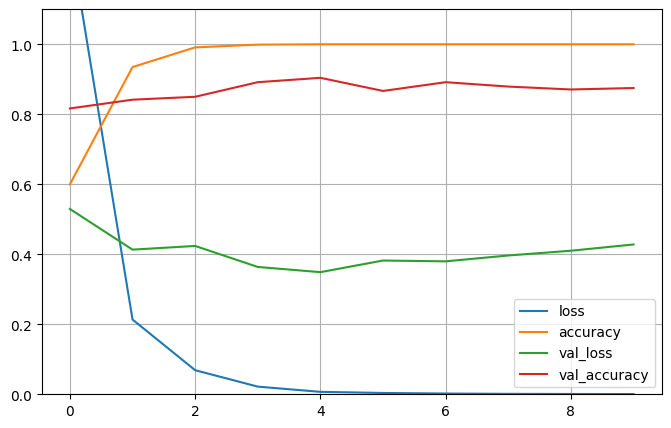

In [10]:
# Menampilkan grafik untuk akurasi training dan validasi beserta dengan lossnya masing-masing
pd.DataFrame(model_fit.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.show()

In [11]:
# Melakukan evaluasi pada model dengan menggunakan dataset testing (Untuk melihat akurasi dan loss)
model.evaluate(test_x_vgg, test_y)

8/8 [==============================] - 0s 4ms/step - loss: 0.5689 - accuracy: 0.8708


[0.5689412355422974, 0.8708333373069763]

Membuat Confusion Matrix

In [12]:
# Menambil nilai prediksi untuk semua gambar pada dataset testing menggunakan model yang sudah dibuat
y_probs = model.predict(test_x_vgg)
# Mengambil salah satu class berdasarkan nilai tertinggi untuk klasifikasi
y_preds = y_probs.argmax(axis = 1)

8/8 [==============================] - 0s 4ms/step


In [13]:
# Fungsi untuk membuat confusion matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0] 

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

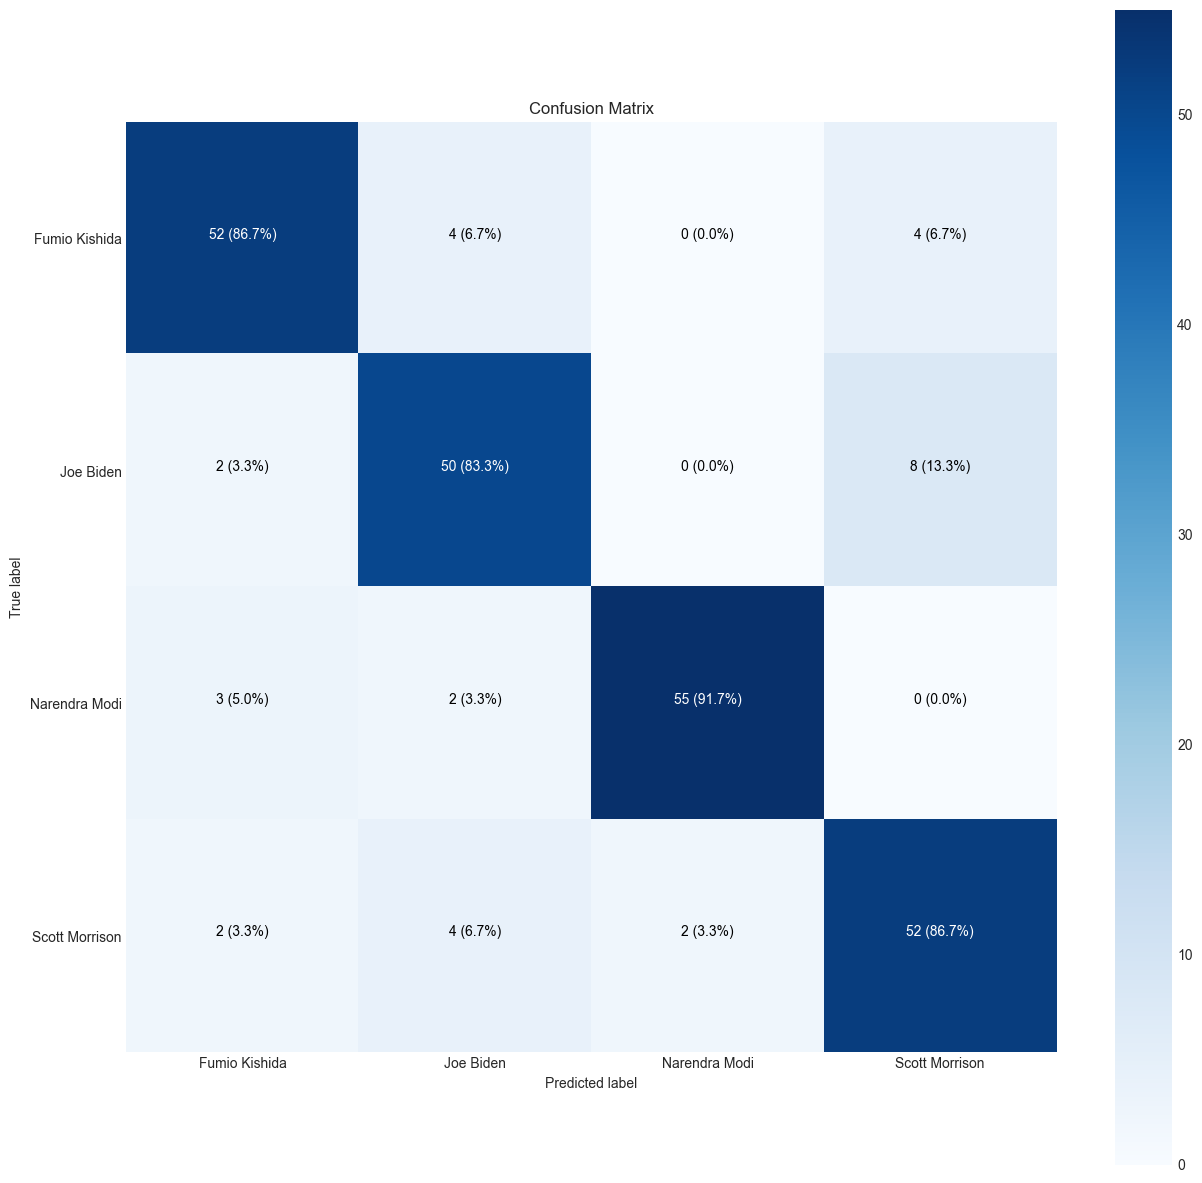

In [14]:
# Membuat variabel untuk menamai class sesuai dengan value pada classnya
class_names = ["Fumio Kishida", "Joe Biden", "Narendra Modi", "Scott Morrison"]

# Membuat grafik confusion matrix
plt.style.use('seaborn-v0_8-dark')
make_confusion_matrix(y_true=test_y, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

Membuat Classification Report

In [15]:
# Menampilkan classification report, seperti precision, recall, f1-score, dan support
print(classification_report(test_y, y_preds, target_names=class_names))

                precision    recall  f1-score   support

 Fumio Kishida       0.88      0.87      0.87        60
     Joe Biden       0.83      0.83      0.83        60
 Narendra Modi       0.96      0.92      0.94        60
Scott Morrison       0.81      0.87      0.84        60

      accuracy                           0.87       240
     macro avg       0.87      0.87      0.87       240
  weighted avg       0.87      0.87      0.87       240

